In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0  4424k      0  0:00:23  0:00:23 --:--:-- 5413k


In [5]:
!file *.root
file = uproot.open("run291694.mc.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4

[{nMuons: 2, isCINT: True, isCMUL: False, isCMSL: True, ... 2, 0]}] 
 [{nMuonsGen: 2, Muon_GenE: [10.3, 20.7], ... Muon_GenMotherPDGCode: [443, 443]}] 

[[], [], [], [], [], [], ... E: 11.7, charge: -1, thetaAbs: 5.79, matched: 0})]]
a


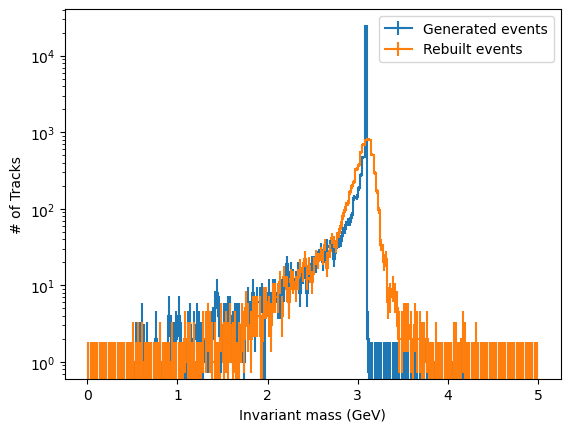

In [10]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

vector.register_awkward() 

DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

#!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/nbPmKbcsJvZrjjx/291694/AnalysisResults.root' > run291694.mc.root
#!file *.root
#file = uproot.open("run291694.mc.root")
#file.keys()
#events = file["eventsTree"]
#gen = file["genTree"]

#def data_url(run,is_mc):
#    basesrc="https://cernbox.cern.ch/remote.php/dav/public-files/VJZ5whMyF5Kxldd/dimuonData_LHC18m"
#    if is_mc==True:
#        basesrc+="MC"
#    return f"{basesrc}/{run}/AnalysisResults.root"

#def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
#    datatype="mc" if is_mc else "data"
#    print({dest},"/run",{run},".",{datatype},".root")
#    return f"{dest}/run{run}.{datatype}.root"

#def copy_cmd(run,is_mc,dest):
#    return f"curl '{data_url(run,is_mc)}' > {data_file_path(run,is_mc,dest)}"

def getTracks(events, gen):
    i = gen["Muon_GenMotherPDGCode"] == 443
    j = i[:,0]
    tracks = events[j]
    return ak.zip({
        "px":tracks["Muon_Px"],
                    "py":tracks["Muon_Py"],
                    "pz":tracks["Muon_Pz"],
                    "E":tracks["Muon_E"],
                    "charge":tracks["Muon_Charge"],
                    "thetaAbs":tracks["Muon_thetaAbs"],
                    "matched":tracks["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def getTracksGenerated(gen):
    i = gen["Muon_GenMotherPDGCode"] == 443
    j = i[:,0]
    tracksGen = gen[j]
    return ak.zip({ "px":tracksGen["Muon_GenPx"],
                   "py":tracksGen["Muon_GenPy"],
                   "pz":tracksGen["Muon_GenPz"],
                   "E":tracksGen["Muon_GenE"],
                   "GenMotherPDGCode":tracksGen["Muon_GenMotherPDGCode"]},
                    with_name='Momentum4D')

def scan(dataDescription1, dataDescription2, 
              hMag:hist.Hist, hPhi:hist.Hist, hInvMassGen:hist.Hist, hInvMassRebuilt:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch1, batch2 in zip(uproot.iterate(dataDescription1,
                                ["nMuons", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True), 
                             uproot.iterate(dataDescription2,
                                ["nMuonsGen", "Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 step_size="100 MB", report=True)):
        events=batch1[0] # batch[1] is the report info
        gen=batch2[0]
        print(events, "\n", gen, "\n")
        if len(events) < 1000:
            print("something is wrong",batch1[1], batch2[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(events, gen)
        tracksGen = getTracksGenerated(gen)
        
        pairs = ak.combinations(tracks, 2)
        pairs_gen = ak.combinations(tracksGen, 2)
        one, two = ak.unzip(pairs)
        one_gen, two_gen = ak.unzip(pairs_gen)
        
        #opposite_charge_cut = one.charge + two.charge == 0
        
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        invariant_mass = (one + two).mass
        invariant_mass_gen = (one_gen + two_gen).mass
        
        hMag.fill(ak.flatten(tracks.p))
        hPhi.fill(ak.flatten(tracks.phi)) 
        hInvMassRebuilt.fill(ak.flatten(invariant_mass))
        hInvMassGen.fill(ak.flatten(invariant_mass_gen))

        print(pairs)
        print("a")

        if verbose:
            print(batch1[1], "\n", batch2[1])

vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMass_gen = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass'))
vhInvMass_rebuilt = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass'))
            
scan(dataDescription1=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
     dataDescription2=f"{BASEDIR}/run291694.{DATATYPE}.root:genTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hInvMassGen=vhInvMass_gen, hInvMassRebuilt=vhInvMass_rebuilt,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta>0))

vhInvMass_gen.plot(label="Generated events")
vhInvMass_rebuilt.plot(label="Rebuilt events")
plt.xlabel("Invariant mass (GeV)")
plt.ylabel("# of Tracks")
plt.yscale("log")
plt.legend()